<a href="https://colab.research.google.com/github/YulayNaumov/-ODS/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_ODS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import random
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import sklearn as skl
import plotly.graph_objects as go
import torch
import os
import torch.nn as nn
import shutil
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import patoolib
import copy
import matplotlib
import albumentations as A
import torch.optim as optim
import cv2
try:
  import transformers # Huggingface’s transformers library
except:
  !pip install transformers
  import transformers

from albumentations.pytorch import ToTensorV2
from pandas.core.common import random_state
from google.colab import files
from sklearn.utils import resample
from sklearn.datasets import make_classification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from PIL import Image
from sklearn.metrics import confusion_matrix
from transformers import AutoModel, AutoTokenizer , BertTokenizerFast
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 7.0)

In [6]:
os.makedirs("dataset", exist_ok=True)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
patoolib.extract_archive("/content/drive/MyDrive/xray-lung-segmentation.zip", outdir='/content/dataset')

patool: Extracting /content/drive/MyDrive/xray-lung-segmentation.zip ...
patool: running /usr/bin/7z x -o/content/dataset -- /content/drive/MyDrive/xray-lung-segmentation.zip
patool: ... /content/drive/MyDrive/xray-lung-segmentation.zip extracted to `/content/dataset'.


'/content/dataset'

In [9]:
os.makedirs("/content/dataset/test", exist_ok=True)
os.makedirs("/content/dataset/train", exist_ok=True)

In [10]:
patoolib.extract_archive("/content/dataset/data_test.zip", outdir='/content/dataset/test')
patoolib.extract_archive("/content/dataset/data_train.zip", outdir='/content/dataset/train')

patool: Extracting /content/dataset/data_test.zip ...
patool: running /usr/bin/7z x -o/content/dataset/test -- /content/dataset/data_test.zip
patool: ... /content/dataset/data_test.zip extracted to `/content/dataset/test'.
patool: Extracting /content/dataset/data_train.zip ...
patool: running /usr/bin/7z x -o/content/dataset/train -- /content/dataset/data_train.zip
patool: ... /content/dataset/data_train.zip extracted to `/content/dataset/train'.


'/content/dataset/train'

In [11]:
img_dir = '/content/dataset/train/data_train'
for filename in os.listdir(img_dir):
    if '_preview' in filename:
        os.remove(os.path.join(img_dir, filename))
    if "idx.txt" in filename:
      os.remove(os.path.join(img_dir, filename))

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        #print(img_name)
        image = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.img_dir, img_name.replace('.png', '_msk.png')), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))
            
            #mask = torch.from_numpy(mask)
        return image, mask

In [4]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=255, min_width=255),
        A.RandomCrop(255, 255),
        A.ShiftScaleRotate(shift_limit=0.00, scale_limit=0.00, rotate_limit=0, p=0.0),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

In [5]:
img_dir = '/content/dataset/train/data_train'
img_names_train = []
img_names_test = []
k = 0
for i in os.listdir(img_dir):
  k += 1
  if ('_msk' not in i) :
    img_names_train.append(i)
  if ('_msk' not in i)  and (k > 566) :
    img_names_test.append(i)

dataset_train = SegmentationDataset(img_dir, img_names_train, train_transform)
dataset_test = SegmentationDataset(img_dir, img_names_test, train_transform)
dataloader = DataLoader(dataset_train, batch_size=5, shuffle=True, num_workers=0)
dataloader_test = DataLoader(dataset_test, batch_size=5, shuffle=True, num_workers=0)

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        idx += 1
    plt.tight_layout()
    plt.show()

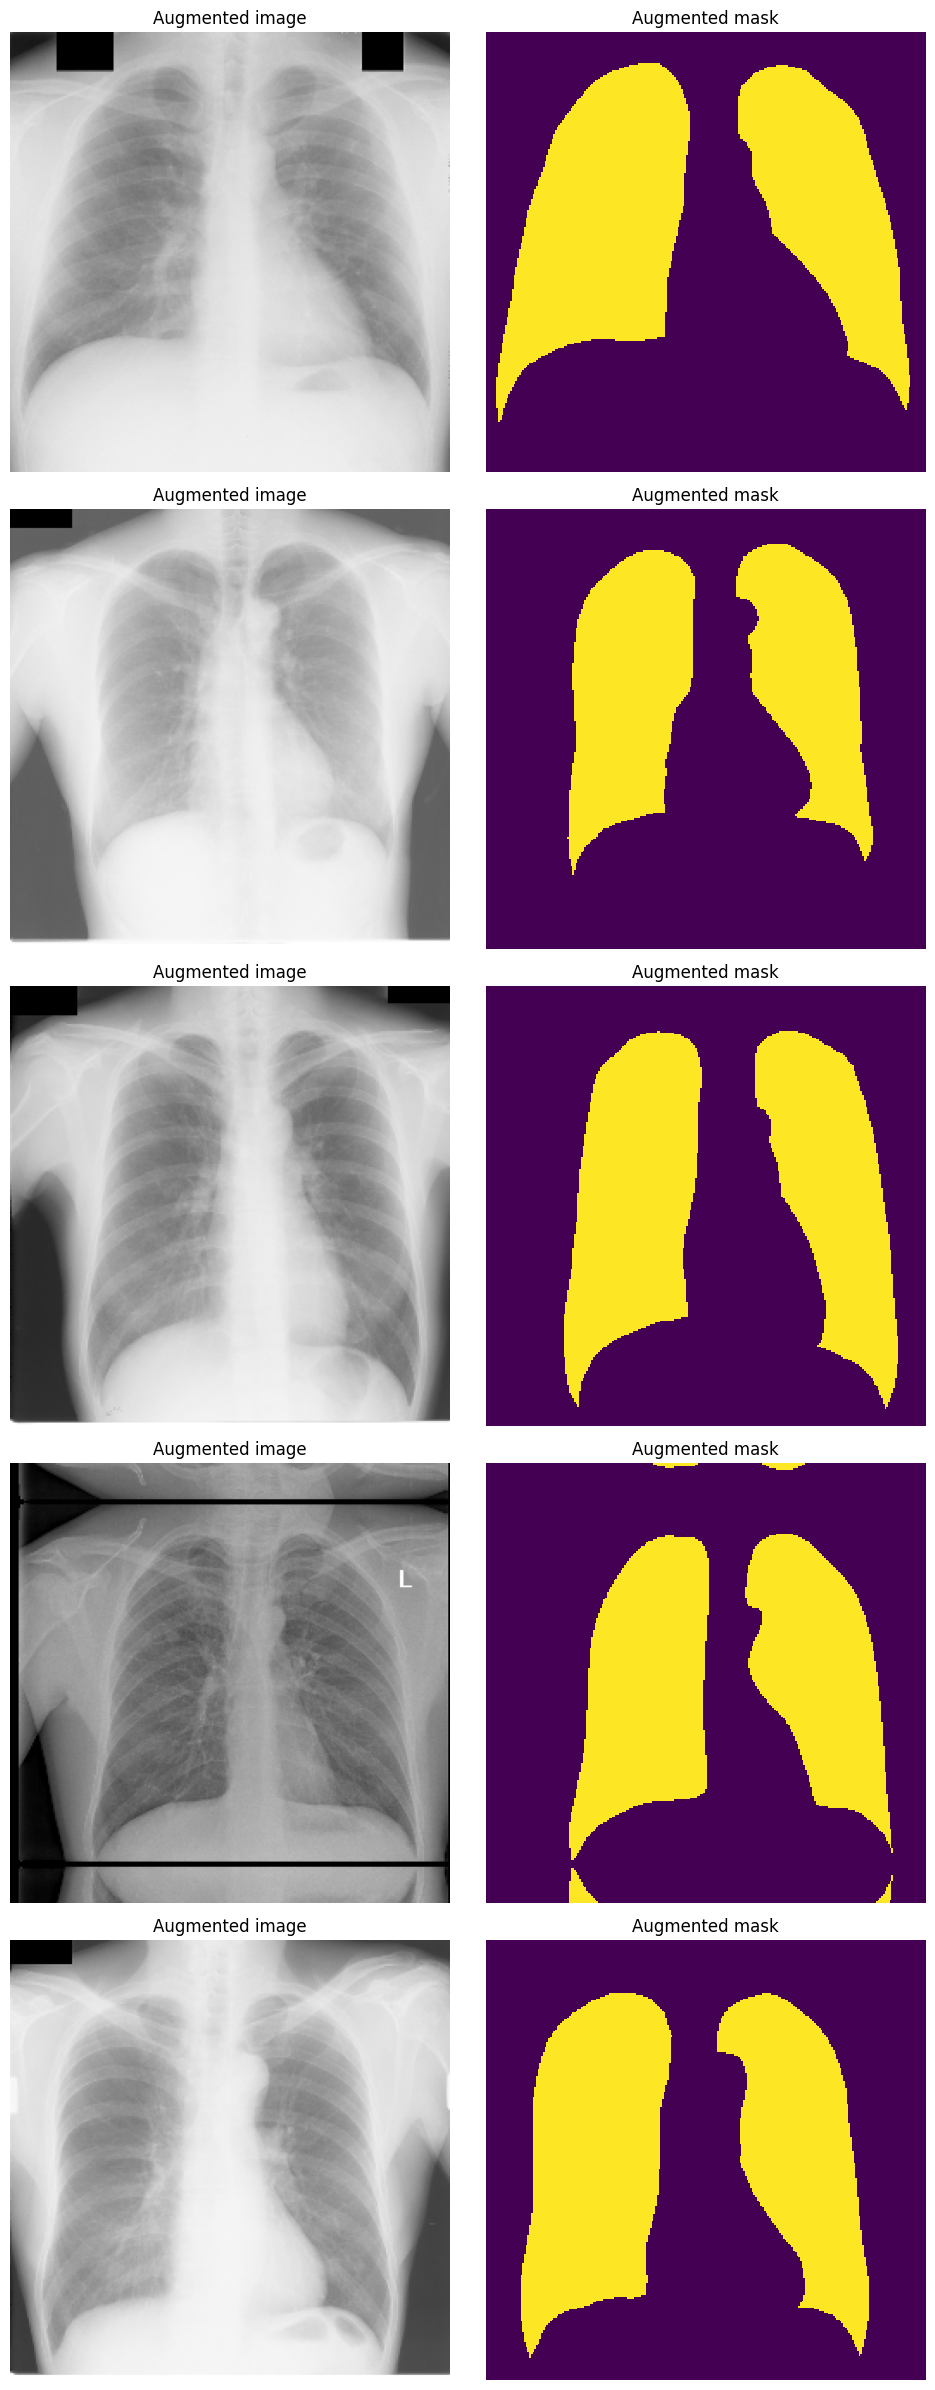

In [ ]:
visualize_augmentations(dataset_test, 5)

In [6]:
# Инициализация модели
class Model(nn.Module):
    def __init__(self, nc):
        super().__init__()

        #self.act = nn.ReLU6()
        self.act = nn.GELU()
        self.pool = nn.MaxPool2d(2,2)

        self.gn0_1 = nn.GroupNorm(2, nc)
        self.gn0_2 = nn.GroupNorm(2, nc)
        self.gn0_3 = nn.GroupNorm(2, nc)
        self.gn0_4 = nn.GroupNorm(2, nc)

        self.gn1_1 = nn.GroupNorm(2, 2*nc)
        self.gn1_2 = nn.GroupNorm(2, 2*nc)
        self.gn1_3 = nn.GroupNorm(2, 2*nc)
        self.gn1_4 = nn.GroupNorm(2, 2*nc)

        self.gn3_1 = nn.GroupNorm(2, 2*nc)
        self.gn3_2 = nn.GroupNorm(2, 2*nc)
        self.gn3_3 = nn.GroupNorm(2, 2*nc)
        self.gn3_4 = nn.GroupNorm(2, 2*nc)

        self.gn4_1 = nn.GroupNorm(2, 2*nc)
        self.gn4_2 = nn.GroupNorm(2, 2*nc)
        self.gn4_3 = nn.GroupNorm(2, 2*nc)
        self.gn4_4 = nn.GroupNorm(2, 2*nc)       

        self.gn5_1 = nn.GroupNorm(2, 2*nc)
        self.gn5_2 = nn.GroupNorm(2, 2*nc)
        self.gn5_3 = nn.GroupNorm(2, 2*nc)
        self.gn5_4 = nn.GroupNorm(2, 2*nc)

        self.gn6_1 = nn.GroupNorm(2, 2*nc)
        self.gn6_2 = nn.GroupNorm(2, 2*nc)
        self.gn6_3 = nn.GroupNorm(2, 2*nc)
        self.gn6_4 = nn.GroupNorm(2, 2*nc)        


        self.gn2_1 = nn.GroupNorm(2, nc)
        self.gn2_2 = nn.GroupNorm(2, nc)
        self.gn2_3 = nn.GroupNorm(2, nc)
        self.gn2_4 = nn.GroupNorm(2, nc)        


        self.conv0_1 = nn.Conv2d(3, nc, 7)
        self.conv0_2 = nn.Conv2d(nc, nc, 3)
        self.conv0_3 = nn.Conv2d(nc, nc, 3)
        self.conv0_4 = nn.Conv2d(nc, nc, 3)

        self.conv1_1 = nn.Conv2d(nc, 2*nc, 3)
        self.conv1_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv1_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv1_4 = nn.Conv2d(2*nc, 2*nc, 3)


        self.conv3_1 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv3_4 = nn.Conv2d(2*nc, 2*nc, 3)

        self.conv4_1 = nn.Conv2d(4*nc, 2*nc, 3)
        self.conv4_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv4_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv4_4 = nn.Conv2d(2*nc, 2*nc, 3)  
        
        self.conv5_1 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv5_4 = nn.Conv2d(2*nc, 2*nc, 3) 

        self.conv6_1 = nn.Conv2d(4*nc, 2*nc, 3)
        self.conv6_2 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv6_3 = nn.Conv2d(2*nc, 2*nc, 3)
        self.conv6_4 = nn.Conv2d(2*nc, 2*nc, 3)         

        self.conv2_1 = nn.Conv2d(3*nc, nc, 3)
        self.conv2_2 = nn.Conv2d(nc, nc, 3)
        self.conv2_3 = nn.Conv2d(nc, nc, 3)
        self.conv2_4 = nn.Conv2d(nc, 1, 3)


    def forward(self, x):

        _,_,h0,w0 = x.shape
        ######################################## 111111111111111111111111111
        fea = self.conv0_1(x)
        fea = self.gn0_1(fea)
        fea = self.act(fea)
        fea = self.conv0_2(fea)
        fea = self.gn0_2(fea)
        fea = self.act(fea)
        fea = self.conv0_3(fea)
        fea = self.gn0_3(fea)
        fea = self.act(fea)
        fea = self.conv0_4(fea)
        fea = self.gn0_4(fea)
        fea = self.act(fea)        
        

        _,_,h,w = fea.shape
        ######################################## 22222222222222222222222222222222222
        fea_deep = self.conv1_1(fea)
        fea_deep = self.gn1_1(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_2(fea_deep)
        fea_deep = self.gn1_2(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_3(fea_deep)
        fea_deep = self.gn1_3(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv1_4(fea_deep)
        fea_deep = self.gn1_4(fea_deep)
        fea_deep = self.act(fea_deep)

        _,_,ha2,w2 = fea_deep.shape
        fea_deep_2 = self.pool(fea_deep)
        ###########################################     333333333333333333333333333333333333
        fea_deep_2 = self.conv3_1(fea_deep_2)
        fea_deep_2 = self.gn3_1(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_2(fea_deep_2)
        fea_deep_2 = self.gn3_2(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_3(fea_deep_2)
        fea_deep_2 = self.gn3_3(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv3_4(fea_deep_2)
        fea_deep_2 = self.gn3_4(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)

        _,_,ha3,w3 = fea_deep_2.shape
        fea_deep_3 = self.pool(fea_deep_2)
        ###########################################     44444444444444444444444444444444444444444
        fea_deep_3 = self.conv5_1(fea_deep_3)
        fea_deep_3 = self.gn5_1(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_2(fea_deep_3)
        fea_deep_3 = self.gn5_2(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_3(fea_deep_3)
        fea_deep_3 = self.gn5_3(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)
        fea_deep_3 = self.conv5_4(fea_deep_3)
        fea_deep_3 = self.gn5_4(fea_deep_3)
        fea_deep_3 = self.act(fea_deep_3)

        fea_deep_3 = F.upsample(fea_deep_3, size = (ha3,w3), mode = 'bilinear')
        fea_deep_2 = torch.cat((fea_deep_2, fea_deep_3), axis = 1)
        del fea_deep_3

        ###########################################     333333333333333333333333333333333333
        fea_deep_2 = self.conv6_1(fea_deep_2)
        fea_deep_2 = self.gn6_1(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_2(fea_deep_2)
        fea_deep_2 = self.gn6_2(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_3(fea_deep_2)
        fea_deep_2 = self.gn6_3(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)
        fea_deep_2 = self.conv6_4(fea_deep_2)
        fea_deep_2 = self.gn6_4(fea_deep_2)
        fea_deep_2 = self.act(fea_deep_2)

        fea_deep_2 = F.upsample(fea_deep_2, size = (ha2,w2), mode = 'bilinear')
        fea_deep = torch.cat((fea_deep, fea_deep_2), axis = 1)
        del fea_deep_2
        #######################################      222222222222222222222222222222222222222
        fea_deep = self.conv4_1(fea_deep)
        fea_deep = self.gn4_1(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_2(fea_deep)
        fea_deep = self.gn4_2(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_3(fea_deep)
        fea_deep = self.gn4_3(fea_deep)
        fea_deep = self.act(fea_deep)
        fea_deep = self.conv4_4(fea_deep)
        fea_deep = self.gn4_4(fea_deep)
        fea_deep = self.act(fea_deep)

        fea_deep = F.upsample(fea_deep, size = (h,w), mode = 'bilinear')
        #########################################         1111111111111111111111111111111111111111111
        fea = torch.cat((fea, fea_deep), axis = 1)
        del fea_deep
        fea = self.conv2_1(fea)
        fea = self.gn2_1(fea)
        fea = self.act(fea)
        fea = self.conv2_2(fea)
        fea = self.gn2_2(fea)
        fea = self.act(fea)
        fea = self.conv2_3(fea)
        fea = self.gn2_3(fea)
        fea = self.act(fea)

        fea = self.conv2_4(fea)        

        fea = F.upsample(fea, size = (h0,w0), mode = 'bilinear')

        return fea

model = Model(120)

In [17]:
#Критерии полезны для обучения нейронной сети. Учитывая входные данные и цель, они вычисляют градиент в соответствии с заданной функцией потерь
criterion = nn.BCEWithLogitsLoss()
#torch.optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, а интерфейс достаточно общий, так что более сложные методы могут быть также легко интегрированы в будущем.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
torch.cuda.is_available()

True

In [8]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded

In [20]:
loss_sum = []
epochs = 20
for epoch in range(epochs):  # многократное прохождение по набору данных
    avg_loss = 0
    running_loss = 0.0
    for i, data in enumerate(dataloader,0):
        # получаем входные данные; данные - это список [inputs, labels].
        img, mask = data#.values()
        img = img.to(device)
        mask = mask.to(device)

        # обнуляем градиенты параметров
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(img)
        loss = criterion(outputs, mask)
        loss_sum.append(loss.item())
        loss.backward()
        optimizer.step()
        # вывести статистику обучения
        running_loss += loss.item() 

        if i % 25 == 0:    # вывести каждые 10 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1:.3f}')
          running_loss = 0.0

    scheduler.step()

print('Finished Training')

KeyboardInterrupt: ignored

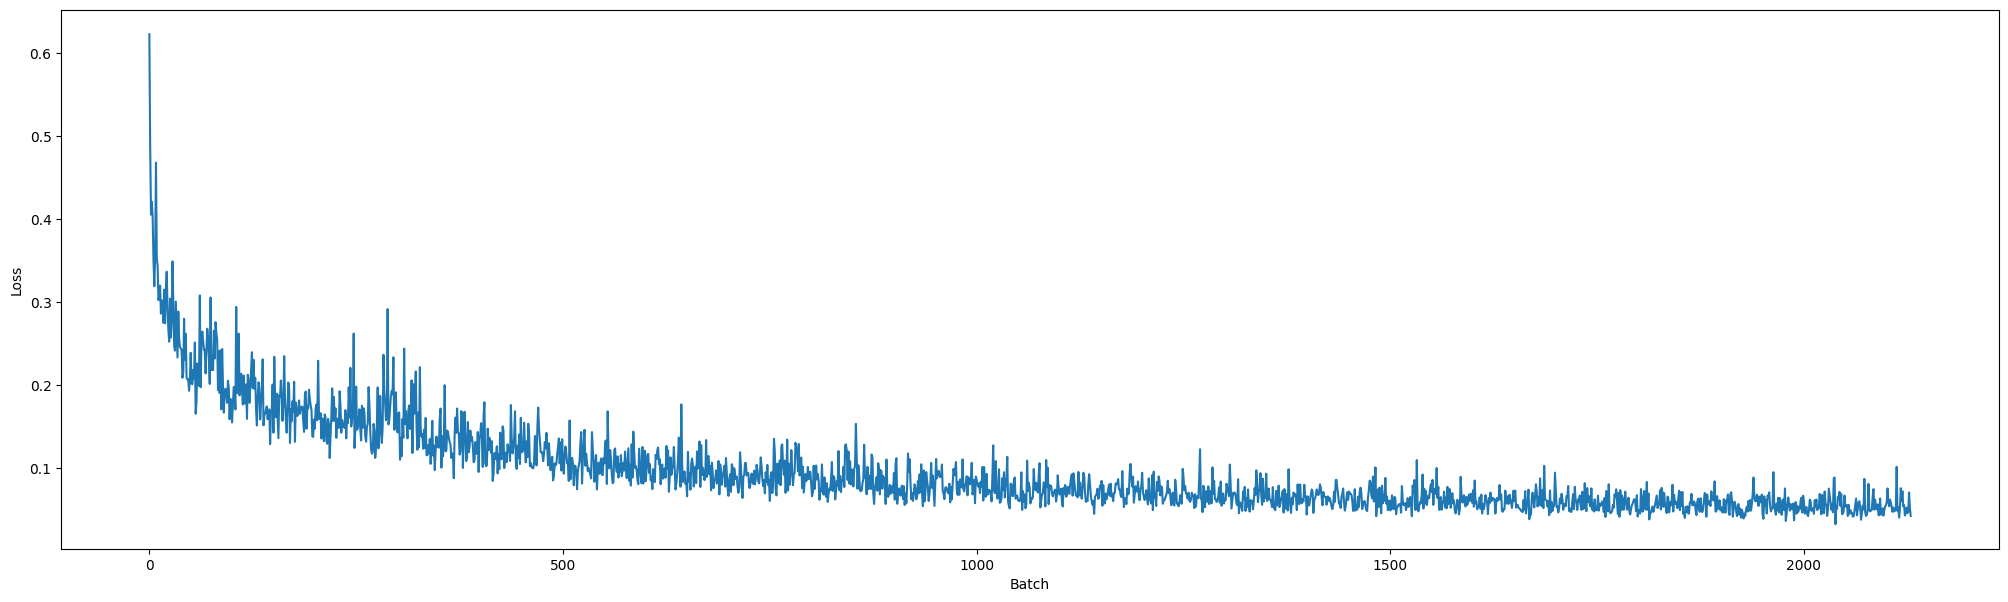

In [ ]:
plt.plot(loss_sum)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [9]:
model.load_state_dict(torch.load('model2.pth', map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [10]:
def score_model(model1, metric, data):
  #model1.eval()
  scores = 0
  threshold = 0.5
  for X_batch, Y_label in data:
    y_pred = model1(X_batch.to(device))
    y_pred = (y_pred > threshold).float()
    scores += metric(y_pred, Y_label.to(device)).mean().item()

  return scores/len(data)

In [ ]:
acc = score_model(model, iou_pytorch, dataloader)
print('Точность тренировочного набора:', acc)

Точность тренировочного набора: 0.9022535690119569


In [ ]:
acc = score_model(model, iou_pytorch, dataloader_test)
print('Точность тестовго набора:', acc)

Точность тестовго набора: 0.9040000518163045


In [ ]:
acc = score_model(model, iou_pytorch, dataloader_test)
print('Точность тренировочного для слабой сетки набора:', acc)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [88]:
#img = dataset_train[10][0].unsqueeze(0)
img = dataset_test[0].unsqueeze(0)
img = img.to(device)
pred = model(img)
print(type(pred))
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


<class 'torch.Tensor'>


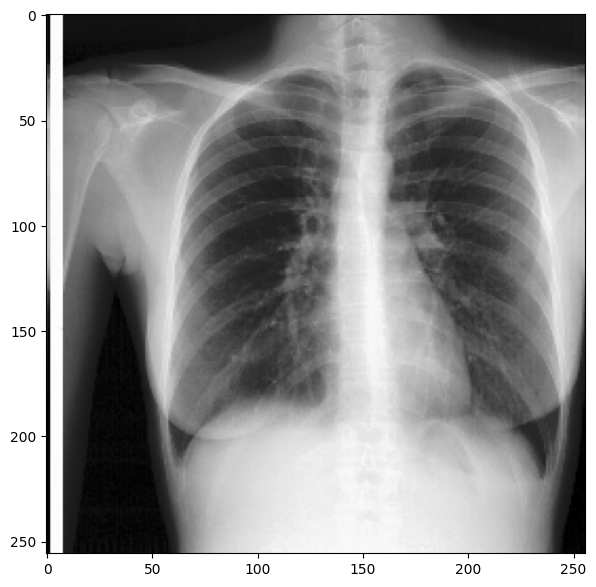

In [89]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

In [90]:
cv2.imwrite('pred.jpg', pred)

True

In [91]:
#rt, mask = cv2.threshold(pred,  127, 255, cv2.THRESH_BINARY)
img = cv2.imread('pred.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# выбор пороговых значений для желтого и фиолетового
#lower_yellow = np.array([20, 100, 100])
#upper_yellow = np.array([30, 255, 255])
#lower_violet = np.array([130, 100, 100])
#upper_violet = np.array([140, 255, 255])
# создание маски для желтых и фиолетовых пикселей
#mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
#mask_violet = cv2.inRange(hsv, lower_violet, upper_violet)
# объединение масок
#mask = mask_yellow + mask_violet
# применение маски к исходному изображению
#result = cv2.bitwise_and(img, img, mask=mask)

In [92]:
hsv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

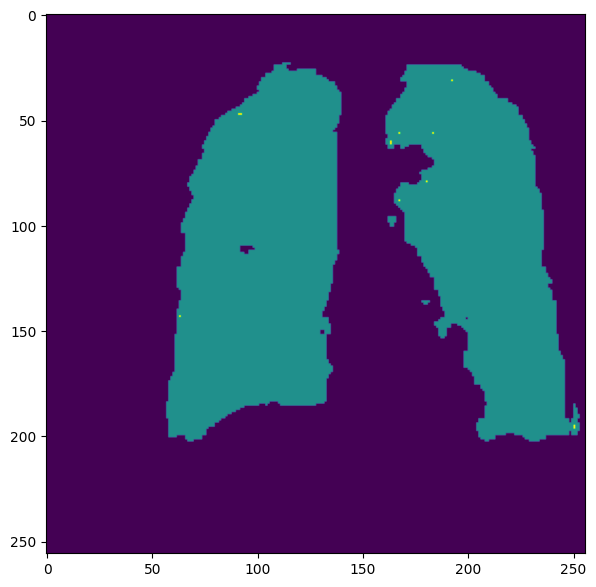

In [93]:
plt.imshow(hsv)

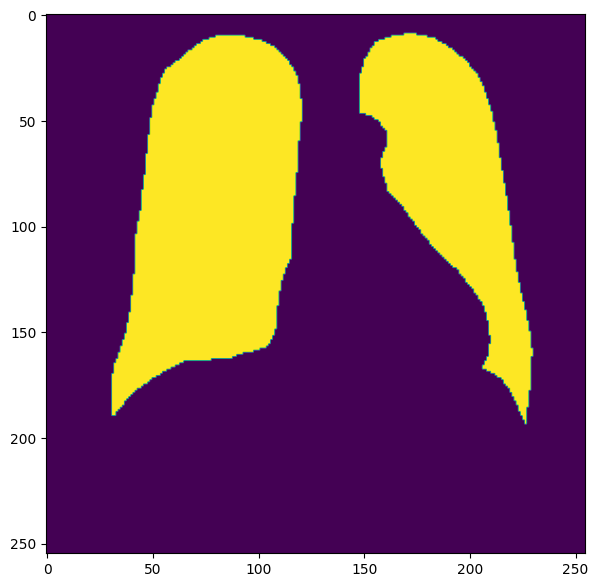

In [76]:
msk = dataset_train[10][1].unsqueeze(0)
msk = msk.to(device)
msk = msk.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(msk)

In [77]:
class SegmentationDataset_Test(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        image = cv2.imread(os.path.join(self.img_dir, img_name), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            
        return image

In [78]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=255, min_width=255),
        A.RandomCrop(255, 255,p = 0),
        A.ShiftScaleRotate(shift_limit=0.00, scale_limit=0.00, rotate_limit=0, p=0.0),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

In [79]:
img_dir = '/content/dataset/test/data_test'
img_names = []
for i in os.listdir(img_dir):
    img_names.append(i)

dataset_test = SegmentationDataset_Test(img_dir, img_names, train_transform)
data = DataLoader(dataset_test, batch_size=5, shuffle=True, num_workers=0)

In [80]:
images_list = os.listdir('/content/dataset/test/data_test')
images_list = sorted(images_list, key=lambda x: str(x.split('.')[0]))
for i in range(len(images_list)): 
  images_list[i] = images_list[i].replace(".png", "")

In [81]:
i = 0
j = 0
seg_results = []
for im in dataset_test:
  im = im.unsqueeze(0)
  im = im.to(device)
  pred = model(im)
  #pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
  pred_list = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
  cv2.imwrite('pred.jpg', pred_list)
  img = cv2.imread('pred.jpg')
  mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #_, mask = cv2.threshold(pred_list, 127, 255, cv2.THRESH_TRUNC)
  for r in range(mask.shape[0]):
    for c in range(mask.shape[1]):
      for val in [mask[r,c]]:
        #seg_results = [(r, c, val)]
        pixel_id = f"{images_list[j]}_r{r}_c{c}"
        pixel_val = 1 if val > 0.025 else 0
        seg_results.append((pixel_id,pixel_val))
        #df_out = df_out.append({'id': pixel_id, 'val': pixel_val}, ignore_index=True)
  j += 1
  print('Фотка добавлена №',i)
  i += 1

Фотка добавлена № 0
Фотка добавлена № 1
Фотка добавлена № 2
Фотка добавлена № 3
Фотка добавлена № 4
Фотка добавлена № 5
Фотка добавлена № 6
Фотка добавлена № 7
Фотка добавлена № 8
Фотка добавлена № 9
Фотка добавлена № 10
Фотка добавлена № 11
Фотка добавлена № 12
Фотка добавлена № 13
Фотка добавлена № 14
Фотка добавлена № 15
Фотка добавлена № 16
Фотка добавлена № 17
Фотка добавлена № 18
Фотка добавлена № 19
Фотка добавлена № 20
Фотка добавлена № 21
Фотка добавлена № 22
Фотка добавлена № 23
Фотка добавлена № 24
Фотка добавлена № 25
Фотка добавлена № 26
Фотка добавлена № 27
Фотка добавлена № 28
Фотка добавлена № 29
Фотка добавлена № 30
Фотка добавлена № 31
Фотка добавлена № 32
Фотка добавлена № 33
Фотка добавлена № 34
Фотка добавлена № 35
Фотка добавлена № 36
Фотка добавлена № 37
Фотка добавлена № 38
Фотка добавлена № 39
Фотка добавлена № 40
Фотка добавлена № 41
Фотка добавлена № 42
Фотка добавлена № 43
Фотка добавлена № 44
Фотка добавлена № 45
Фотка добавлена № 46
Фотка добавлена № 47
Фо

# **Черновики**

In [ ]:
pred_list = []
i = 0
for im in dataset_test:
  im = im.unsqueeze(0)
  im = im.to(device)
  pred = model(im)
  #pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)
  pred_list.append(pred)
  print('Фотка добавлена №',i)
  i += 1

In [ ]:
for i in range(len(pred_list)):
  pred_list[i] = F.sigmoid(pred_list[i].detach()).cpu().numpy()[0].transpose(1,2,0)

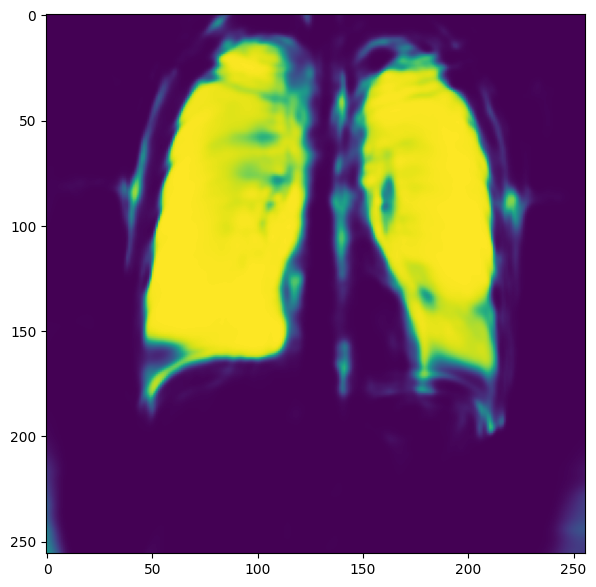

In [ ]:
plt.imshow(pred_list[1])

In [ ]:
msk = []
j = 0
for i in pred_list:
  _, mask = cv2.threshold(i, 127, 255, cv2.THRESH_TRUNC)
  msk.append(mask)
  j += 1

In [ ]:
msk[4]

array([[0.02455271, 0.02565656, 0.02707145, ..., 0.02923359, 0.02885659,
        0.0284476 ],
       [0.02394974, 0.02561463, 0.02742253, ..., 0.02696626, 0.02676913,
        0.02677739],
       [0.02312451, 0.02484689, 0.02684512, ..., 0.02477661, 0.02475015,
        0.0248621 ],
       ...,
       [0.07164136, 0.08622544, 0.10104474, ..., 0.0122632 , 0.01211653,
        0.011623  ],
       [0.07062714, 0.08331354, 0.0960245 , ..., 0.0123277 , 0.01199371,
        0.01131486],
       [0.0684487 , 0.08120672, 0.09302423, ..., 0.01301413, 0.01198288,
        0.01147454]], dtype=float32)

In [ ]:
images_list = os.listdir('/content/dataset/test/data_test')
images_list = sorted(images_list, key=lambda x: str(x.split('.')[0]))
for i in range(len(images_list)): 
  images_list[i] = images_list[i].replace(".png", "")

In [ ]:
seg_results = []
j = 0
for i in msk:
  for r in range(i.shape[0]):
    for c in range(i.shape[1]):
      for val in [i[r,c]]:
        #seg_results = [(r, c, val)]
        pixel_id = f"{images_list[j]}_r{r}_c{c}"
        pixel_val = 1 if val > 0.025 else 0
        seg_results.append((pixel_id,pixel_val))
        #df_out = df_out.append({'id': pixel_id, 'val': pixel_val}, ignore_index=True)
  j += 1

# **Отправка на Кагл**

In [83]:
df_out = pd.DataFrame(seg_results, columns=['id', 'val'])

In [99]:
df_out

,id,val
0,t000_r0_c0,0
1,t000_r0_c1,0
2,t000_r0_c2,0
3,t000_r0_c3,0
4,t000_r0_c4,0
...,...,...
9830395,t393_r255_c251,0
9830396,t393_r255_c252,0
9830397,t393_r255_c253,0
9830398,t393_r255_c254,0


In [94]:
file = files.upload()

Saving kaggle (1).json to kaggle (1).json


In [95]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [96]:
df_out.to_csv('seg_results.csv', index=False)

In [97]:
!pip install --upgrade pip
!pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
#Отправляем решение
!kaggle competitions submit -c xray-lung-segmentation -m 'Submition from Colab' -f seg_results.csv

100% 151M/151M [00:01<00:00, 88.1MB/s]
Successfully submitted to XRay Lung Segmentation

In [ ]:
a = pd.read_csv('/content/seg_results.csv')

In [ ]:
a

,id,val
0,t000_r0_c0,0
1,t000_r0_c1,0
2,t000_r0_c2,0
3,t000_r0_c3,0
4,t000_r0_c4,0
...,...,...
1499995,t393_r99_c95,1
1499996,t393_r99_c96,1
1499997,t393_r99_c97,1
1499998,t393_r99_c98,1


# Попробеум маски через RLE

In [ ]:
TRAIN_MASKS_CSV_PATH = '/content/seg_results.csv'
TRAIN_MASKS_PATH = '/content/seg_results.csv'

In [ ]:
def read_train_masks():
    global train_masks
    train_masks = pd.read_csv(TRAIN_MASKS_CSV_PATH)
    print(train_masks.head())


read_train_masks()

           id  val
0  t000_r0_c0    0
1  t000_r0_c1    0
2  t000_r0_c2    0
3  t000_r0_c3    0
4  t000_r0_c4    0


In [ ]:
def read_mask_image(car_code, angle_code):
    mask_img_path = TRAIN_MASKS_PATH + '/' + car_code + '_' + angle_code + '_mask.gif';
    mask_img = ndimage.imread(mask_img_path, mode = 'L')
    mask_img[mask_img <= 127] = 0
    mask_img[mask_img > 127] = 1
    return mask_img


def show_mask_image(car_code, angle_code):
    mask_img = read_mask_image(car_code, angle_code)
    plt.imshow(mask_img, cmap = 'Greys_r')
    plt.show()


show_mask_image('00087a6bd4dc', '04')

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs


def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


def test_rle_encode():
    test_mask = np.asarray([[0, 0, 0, 0], [0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0]])
    assert rle_to_string(rle_encode(test_mask)) == '7 2 11 2'
    num_masks = len(train_masks['img'])
    print('Verfiying RLE encoding on', num_masks, 'masks ...')
    time_read = 0.0 # seconds
    time_rle = 0.0 # seconds
    time_stringify = 0.0 # seconds
    for mask_idx in range(num_masks):
        img_file_name = train_masks.loc[mask_idx, 'img']
        car_code, angle_code = img_file_name.split('.')[0].split('_')
        t0 = time.clock()
        mask_image = read_mask_image(car_code, angle_code)
        time_read += time.clock() - t0
        t0 = time.clock()
        rle_truth_str = train_masks.loc[mask_idx, 'rle_mask']
        rle = rle_encode(mask_image)
        time_rle += time.clock() - t0
        t0 = time.clock()
        rle_str = rle_to_string(rle)
        time_stringify += time.clock() - t0
        assert rle_str == rle_truth_str
        if mask_idx and (mask_idx % 500) == 0:
            print('  ..', mask_idx, 'tested ..')
    print('Time spent reading mask images:', time_read, 's, =>', \
            1000*(time_read/num_masks), 'ms per mask.')
    print('Time spent RLE encoding masks:', time_rle, 's, =>', \
            1000*(time_rle/num_masks), 'ms per mask.')
    print('Time spent stringifying RLEs:', time_stringify, 's, =>', \
            1000*(time_stringify/num_masks), 'ms per mask.')


test_rle_encode()